In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from skimage.metrics import structural_similarity as ssim

In [2]:
def reorder(coordinates):
    # Sort the four coordinates of the polygon in clockwise order
    # First, find the lowest point
    lowest_point = np.argmax(coordinates[:, 1])
    
    if np.count_nonzero(coordinates[:, 1] == coordinates[lowest_point, 1]) == 2:
        # If the bottom line is parallel to the x-axis, then the upper-left corner must be the first point (p0)
        p0_index = np.argmin(np.sum(coordinates, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return coordinates[[p1_index, p0_index, p3_index, p2_index]]
    else:
        # Find the point that sits to the right of the lowest point
        right_of_lowest = (lowest_point - 1) % 4
        left_of_lowest = (lowest_point + 1) % 4
        angle = np.arctan(-(coordinates[lowest_point][1] - coordinates[right_of_lowest][1]) / 
                          (coordinates[lowest_point][0] - coordinates[right_of_lowest][0]))
        
        # assert angle > 0
        if angle <= 0:
            print(angle, coordinates[lowest_point], coordinates[right_of_lowest])
            
        if angle / np.pi * 180 > 45:
            # This point is p2
            p2_index = lowest_point
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return coordinates[[p1_index, p0_index, p3_index, p2_index]]
        else:
            # This point is p3
            p3_index = lowest_point
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return coordinates[[p1_index, p0_index, p3_index, p2_index]]


In [3]:
def Reflect101(img,filter_size):
  '''
    Do not use loop (like while and for)
    Do not use libraries
    calculate averaging filter
    input(s):
      img (ndarray): input image
      filter_size (ndarray): filter size
    output(s):
      image (ndarray): computed Reflect101
  '''
  image = np.pad(img, pad_width=((filter_size//2, filter_size//2), (filter_size//2, filter_size//2)), mode='reflect', reflect_type='odd')

  return image

In [4]:
def Averaging_Blurring(img, filter_size):
  '''
    Do not use libraries
    input(s):
      img (ndarray): input image
      filter_size (ndarray): filter size
    output(s):
      result (ndarray): computed averaging blurring
  '''
  image = Reflect101(img, filter_size)
  result = np.zeros((img.shape))
  avg_filter = np.ones((filter_size , filter_size))/ (filter_size * filter_size)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      result[i,j] = np.convolve(image[i :i + filter_size , j : j + filter_size].flatten(), avg_filter.flatten() , mode='valid')
  # result[:,:] = np.convolve(image[filter_size//2 : - filter_size //2 , filter_size //2 : -filter_size //2] , avg_filter , mode='valid')

  return result

In [5]:
import math

def calculate_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

In [6]:

def scan(img , kernel_size ,t_lower , t_higher , output_name):
  rectangle = False
  flag_super_no_rectangle = False
  # converting to grayscale
  gray_im = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # apply gaussian blur to remove noise
  blurred_im = cv2.GaussianBlur(gray_im, kernel_size, 0)
  blurred_im = Averaging_Blurring(gray_im , kernel_size[0])
  if blurred_im.dtype != np.uint8:
    blurred_im = blurred_im.astype(np.uint8)
  edges_im_blurred = cv2.Canny(blurred_im, t_lower, t_higher)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
  dilated_im = cv2.dilate(edges_im_blurred, kernel, iterations=2)

  contours, hierarchy = cv2.findContours(dilated_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  card_contour = max(contours, key=cv2.contourArea)
  # peri = cv2.arcLength(card_contour, True)
  # card_contour = cv2.approxPolyDP(card_contour, 0.03 * peri, True)
  img_copy = img.copy()
  cv2.drawContours(img_copy, [card_contour], -1, (0, 0, 255), 2)
  hull = cv2.convexHull(card_contour)
  epsilon = 0.05 * cv2.arcLength(card_contour, True)
  approx = cv2.approxPolyDP(card_contour, epsilon, True)
  if len(approx) != 4:
    epsilon = 0.01 * cv2.arcLength(hull, True)
    approx = cv2.approxPolyDP(hull, epsilon, True)
    if len(approx) != 4:
      rect = cv2.minAreaRect(card_contour)
      box = cv2.boxPoints(rect)
      box = reorder(box)
      print("check")
      # flag_super_no_rectangle = True
      # x, y, w, h = cv2.boundingRect(card_contour)
    else:
      box = reorder(approx.reshape(4, 2)).astype(np.float32)
    # rect = cv2.minAreaRect(hull)
    # box = cv2.boxPoints(rect)
    # box = reorder(box)
    print("not a rectangle")
    # box = np.int0(box)
  else:
    rectangle = True
    box = reorder(approx.reshape(4, 2)).astype(np.float32)
    # # calculate width and height of the rectangle
    # w = np.sqrt(((box[0][0] - box[1][0]) ** 2) + ((box[0][1] - box[1][1]) ** 2))
    # h = np.sqrt(((box[0][0] - box[3][0]) ** 2) + ((box[0][1] - box[3][1]) ** 2))
    # # converting old vertices to new vertices
    # pts1 = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
    # print(pts1)
    # print(box)

  if flag_super_no_rectangle == True :
    # converting old vertices to new vertices
    pts1 = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
  else:
    pts1 = np.float32(box)
  print(pts1)
  # Reshape the points to a 3D array
  points = pts1.reshape((-1, 1, 2))
  points = np.int0(points)
  # # Draw the rectangle on the image
  cv2.polylines(img_copy, [points], isClosed=True, color=(0, 255, 0), thickness=2)
  plt.imshow(img_copy , cmap = 'gray')
  if flag_super_no_rectangle == False and calculate_distance(box[0], box[1]) < calculate_distance(box[0], box[3])  :
    print("yes")
    pts2 = np.float32([[860, 0], [860 , 540], [0, 540] , [0, 0]])
  else :
    pts2 = np.float32([[0, 0], [860 , 0], [860, 540] , [0, 540]])


  if rectangle == False and flag_super_no_rectangle == False:
      if calculate_distance(box[0], box[1]) < calculate_distance(box[0], box[3]) :
        print("yes")
        pts2 = np.float32([[0, 0], [0 , 540], [860, 540] , [860, 0]])
      else :
        pts2 = np.float32([[860, 0], [0 , 0], [0, 540] , [860, 540]])
  if flag_super_no_rectangle == True :
    pts2 = np.float32([[0, 0], [860 , 0], [860, 540] , [0, 540]])
  M = cv2.getPerspectiveTransform(pts1, pts2)
  img_copy = img.copy()
  dst = cv2.warpPerspective(img_copy, M, (860, 540))
  # thresholded_image = cv2.adaptiveThreshold(gray_out, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 79, 10)
  # gray_out = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
  # gray_out = gray_out.astype(np.uint8)
  # _, thresholded_image = cv2.threshold(gray_out.astype(np.float16), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  plt.imshow(dst , cmap = 'gray')
  cv2.imwrite("output.jpg", dst)


  # v_list = reorder(card_contour.reshape(4, 2)).astype(np.float32)
  # # calculate width and height of the rectangle
  # w = np.sqrt(((v_list[0][0] - v_list[1][0]) ** 2) + ((v_list[0][1] - v_list[1][1]) ** 2))
  # h = np.sqrt(((v_list[0][0] - v_list[3][0]) ** 2) + ((v_list[0][1] - v_list[3][1]) ** 2))
  # # converting old vertices to new vertices
  # new_v_list = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
  # # get transform function
  # per_trans = cv2.getPerspectiveTransform(v_list, new_v_list)
  # # apply transform on the image
  # im_copy_2 = img.copy()
  # warped_per = cv2.warpPerspective(im_copy_2, per_trans, (int(w), int(h)))
  # h  = warped_per.shape[0]
  # w = warped_per.shape[1]
  # if h > w :
  #   warped_per = cv2.rotate(warped_per, cv2.ROTATE_90_CLOCKWISE)
  # gray_out = cv2.cvtColor(warped_per, cv2.COLOR_BGR2GRAY)
  # # _,binary = cv2.threshold(gray_out, 128, 255, cv2.THRESH_BINARY)
  # _, binary = cv2.threshold(gray_out, 35, 255, cv2.THRESH_BINARY )
  # #binary = cv2.Threshold(gray_out, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 5)
  # cv2_imshow(binary)
  # cv2.imwrite(warped_per, binary)

-0.14332290915118795 [809 853] [220 768]
[[271. 411.]
 [851. 492.]
 [809. 853.]
 [220. 768.]]


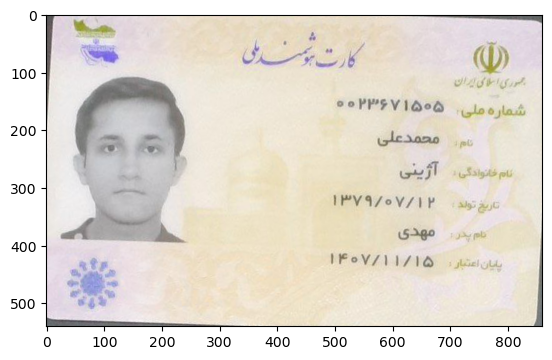

In [7]:
# img7 = cv2.imread('2.jpg')
img7 = cv2.imread('3.jpg')


scan(img7 , (9,9) , 0 , 50 , 'output.jpg')

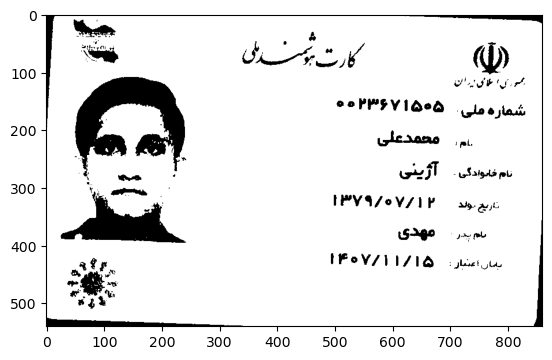

In [8]:
image = cv2.imread("output.jpg", 0)
_, thresholded_image_next = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# thresholded_image_next = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 12)
plt.imshow(thresholded_image_next , cmap='gray')

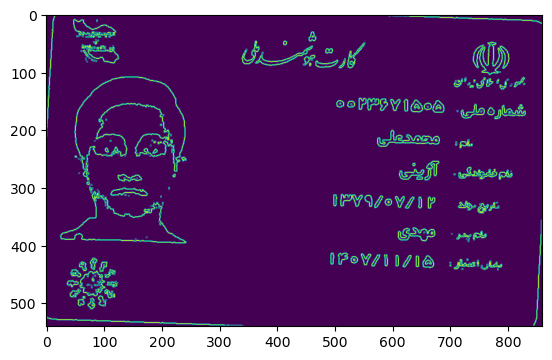

In [9]:
sobelx = cv2.Sobel(thresholded_image_next, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(thresholded_image_next, cv2.CV_64F, 0, 1, ksize=3)
magnitude = np.sqrt(sobelx**2 + sobely**2)
angle = np.arctan2(sobely, sobelx)
plt.imshow(magnitude)

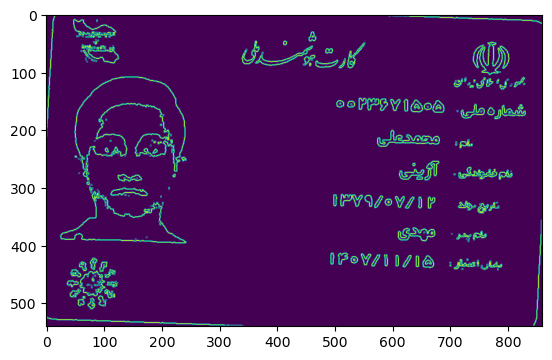

In [10]:
threshold_value = 100
edges = np.zeros_like(magnitude)
edges[magnitude > threshold_value] = 255
plt.imshow(magnitude)

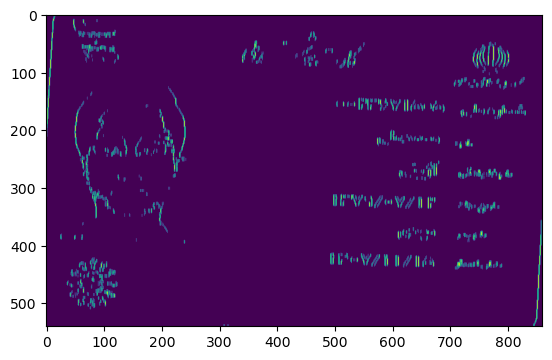

In [11]:
# Define the structuring element
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))

# Apply the open operator
result_after_fo = cv2.morphologyEx(magnitude, cv2.MORPH_OPEN, structuring_element)
plt.imshow(result_after_fo)

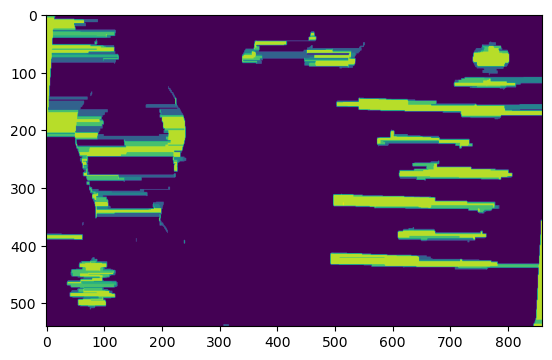

In [12]:
# Define the structuring element
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (71, 1))

# Apply the close operator
result_after_c = cv2.morphologyEx(result_after_fo, cv2.MORPH_CLOSE, structuring_element)
plt.imshow(result_after_c)

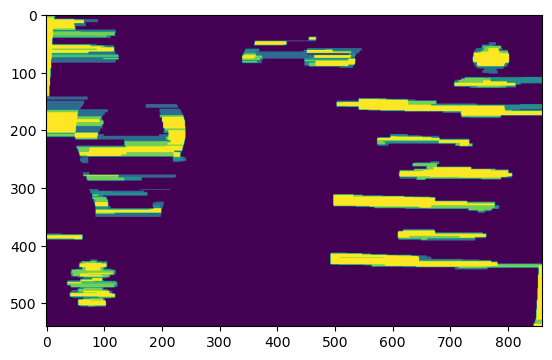

In [13]:
# Define the structuring element
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 1))

# Apply the open operator
result_after_sc = cv2.morphologyEx(result_after_c, cv2.MORPH_OPEN, structuring_element)
plt.imshow(result_after_sc)

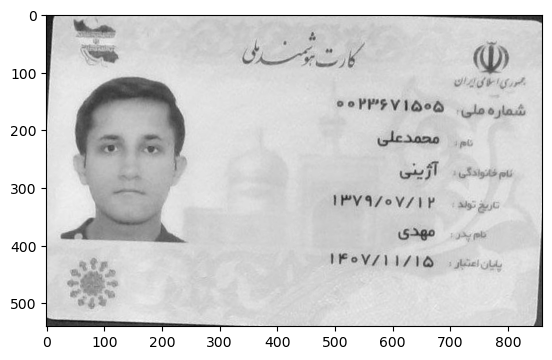

In [14]:
# Find connected components and their statistics
list_of_indexes = []

# Convert the result to uint8 if necessary
if result_after_sc.dtype != np.uint8:
    result_after_sc = result_after_sc.astype(np.uint8)

# Perform connected component analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(result_after_sc)

# Define the minimum area threshold
area_threshold = 1000

# Iterate through connected components
for label in range(1, num_labels):  # Exclude background component (label 0)
    area = stats[label, cv2.CC_STAT_AREA]

    if area > area_threshold:
        # Extract bounding box coordinates
        x, y, width, height = stats[label, cv2.CC_STAT_LEFT], stats[label, cv2.CC_STAT_TOP], \
                              stats[label, cv2.CC_STAT_WIDTH], stats[label, cv2.CC_STAT_HEIGHT]
        list_of_indexes.append((x, y, width, height))
        # Draw bounding rectangle on original image (for visualization)
        # if width > 200 and height > 15 and width > height * 9 :
        #     cv2.rectangle(image, (x, y), (x + width, y + height), (0, 127, 0), 2)
        #     print("draw")

# Display the image with bounding boxes
plt.imshow(image, cmap='gray')


In [15]:
print(list_of_indexes)

[(0, 0, 126, 148), (740, 49, 63, 54), (340, 59, 207, 34), (707, 109, 153, 19), (503, 146, 357, 34), (0, 150, 243, 106), (574, 208, 166, 21), (612, 255, 197, 32), (64, 274, 161, 15), (75, 303, 129, 48), (498, 312, 288, 32), (610, 372, 154, 20), (493, 413, 367, 127), (36, 425, 88, 82)]


In [16]:
def crop_and_replace_boxes(image, boxes):
    # Iterate over the list of boxes
    for box in boxes:
        x, y, width, height = box

        # Crop the box region from the original image
        cropped_box = image[y:y+height, x:x+width]

        # Apply Otsu's thresholding to the cropped box
        _, thresholded_box = cv2.threshold(cropped_box, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # Alternatively, you can use adaptive thresholding:
        # thresholded_box = cv2.adaptiveThreshold(cropped_box, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 2)

        # Replace the pixels in the original image with the thresholded box pixels
        image[y:y+height, x:x+width] = thresholded_box

    return image

In [17]:
img_copy = thresholded_image_next.copy()
img_copy = cv2.resize(img_copy, (1500, 1000))
modified_image = crop_and_replace_boxes(img_copy, list_of_indexes)

In [18]:
# # Define the structuring element
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# # Apply the open operator
# # modified_image = cv2.morphologyEx(modified_image, cv2.MORPH_DILATE, structuring_element)

True

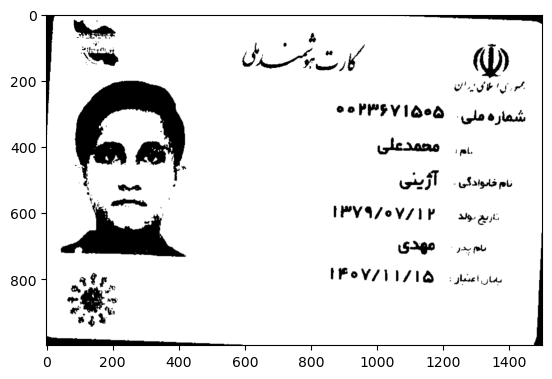

In [19]:
plt.imshow(modified_image  , cmap = 'gray')
# save the image
cv2.imwrite("modified_image.jpg", modified_image)


In [20]:
def make_templates(original_template):
    candidate_templates = []

    # Define the desired number of resize steps
    num_resize_steps = 10

    # Calculate the resize ratios for both width and height
    width_ratios = np.linspace(1, 0.4, num_resize_steps)
    height_ratios = np.linspace(1, 0.4, num_resize_steps)

    # Iterate over the resize ratios
    for width_ratio in width_ratios:
        for height_ratio in height_ratios:
            if abs(width_ratio - height_ratio) == 0:
                # Resize the template
                resized_template = cv2.resize(original_template, (int(original_template.shape[1] * width_ratio), int(original_template.shape[0] * height_ratio)))

                # Apply erosion
                kernel_size = (5, 5)
                kernel = np.ones(kernel_size, np.uint8)
                eroded_template = cv2.erode(resized_template, kernel, iterations=1)

                # Rotate the resized template
                for angle in range(-5, 6):
                    rotated_template = cv2.warpAffine(resized_template, cv2.getRotationMatrix2D((resized_template.shape[1] / 2, resized_template.shape[0] / 2), angle, 1), (resized_template.shape[1], resized_template.shape[0]))
                    # Add the rotated template to the list of candidates
                    candidate_templates.append(rotated_template)

                # Rotate the eroded template
                for angle in range(-5, 6):
                    rotated_template = cv2.warpAffine(eroded_template, cv2.getRotationMatrix2D((eroded_template.shape[1] / 2, eroded_template.shape[0] / 2), angle, 1), (eroded_template.shape[1], eroded_template.shape[0]))
                    # Add the rotated template to the list of candidates
                    candidate_templates.append(rotated_template)

    return candidate_templates


In [21]:
def extract_segments(image):
    _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    matched_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    bounding_rects = []
    for contour in contours:
        if contour is not largest_contour:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_rects.append((x, y, w, h))

    # Remove nested rectangles
    filtered_rectangles = []
    for i in range(len(bounding_rects)):
        include_rect = True
        for j in range(len(bounding_rects)):
            if i != j:
                x1, y1, w1, h1 = bounding_rects[i]
                x2, y2, w2, h2 = bounding_rects[j]
                if x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2:
                    include_rect = False
                    break
        if include_rect:
            filtered_rectangles.append(bounding_rects[i])

    # Remove rectangles that are too small
    filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] > 20 and rect[3] > 20]

    # Remove rectangles that are too large
    filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] < 100 and rect[3] < 100]

    # Remove rectangles where the width is greater than the height
    filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] < rect[3]]

    # Cluster rectangles that are close to each other based on their y-coordinate
    # Sort rectangles by x and y coordinates
    filtered_rectangles.sort(key=lambda x: x[0])
    filtered_rectangles.sort(key=lambda x: x[1])

    clustered_rectangles = []
    for rect in filtered_rectangles:
        if len(clustered_rectangles) == 0:
            clustered_rectangles.append([rect])
        else:
            last_cluster = clustered_rectangles[-1]
            last_rect = last_cluster[-1]
            if abs(rect[1] - last_rect[1]) < 30:
                last_cluster.append(rect)
            else:
                clustered_rectangles.append([rect])

    # Sort each cluster by x-coordinate
    for cluster in clustered_rectangles:
        cluster.sort(key=lambda x: x[0])

    # Save the top 16 rectangles with the largest area from each cluster
    filtered_rectangles = []
    for cluster in clustered_rectangles:
        cluster = sorted(cluster, key=lambda x: x[2] * x[3], reverse=True)
        # if len(cluster) > 16:
        #     cluster = cluster[:16]
        filtered_rectangles += cluster

    # Draw the filtered rectangles
    for cluster in clustered_rectangles:
        for (x, y, w, h) in cluster:
            cv2.rectangle(matched_image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Display the image
    plt.figure(figsize=(20, 20))
    plt.imshow(matched_image)
    plt.show()

    return clustered_rectangles, matched_image
    





def fa_extract_segments(image):
    _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    matched_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    rectangles = []
    for contour in contours:
        if contour is not largest_contour:
            x, y, w, h = cv2.boundingRect(contour)
            rectangles.append((x, y, w, h))

    # Remove nested rectangles
    filtered_rectangles = []
    for i in range(len(rectangles)):
        include_rect = True
        for j in range(len(rectangles)):
            if i != j:
                x1, y1, w1, h1 = rectangles[i]
                x2, y2, w2, h2 = rectangles[j]
                if x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2:
                    include_rect = False
                    break
        if include_rect:
            filtered_rectangles.append(rectangles[i])

    # remove rectangles that are too small
    filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] > 5 and rect[3] > 5]

    # remove rectangles that are too large
    filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] < 100 and rect[3] < 100]

    # remove rectangles that width is greater than height
    # filtered_rectangles = [rect for rect in filtered_rectangles if rect[2] < rect[3]]

    # cluster rectangles that are close to each other into groups based on their y
    # first, sort rectangles by x and y
    filtered_rectangles.sort(key=lambda x: x[0])
    filtered_rectangles.sort(key=lambda x: x[1])

    clustered_rectangles = []
    for rect in filtered_rectangles:
        if len(clustered_rectangles) == 0:
            clustered_rectangles.append([rect])
        else:
            last_cluster = clustered_rectangles[-1]
            last_rect = last_cluster[-1]
            if abs(rect[1] - last_rect[1]) < 30:
                last_cluster.append(rect)
            else:
                clustered_rectangles.append([rect])


    # sort each cluster by x
    for cluster in clustered_rectangles:
        cluster.sort(key=lambda x: x[0])

    # save top 16 rectangles that have the largest area in each cluster
    filtered_rectangles = []
    for cluster in clustered_rectangles:
        cluster = sorted(cluster, key=lambda x: x[2] * x[3], reverse=True)
        # if len(cluster) > 16:
        #     cluster = cluster[:16]
        filtered_rectangles += cluster


    # Draw the filtered rectangles
    for cluster in clustered_rectangles:
        for (x, y, w, h) in cluster:
            cv2.rectangle(matched_image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Display the image
    plt.figure(figsize=(20, 20))
    plt.imshow(matched_image)
    plt.show()
    
    return clustered_rectangles, matched_image





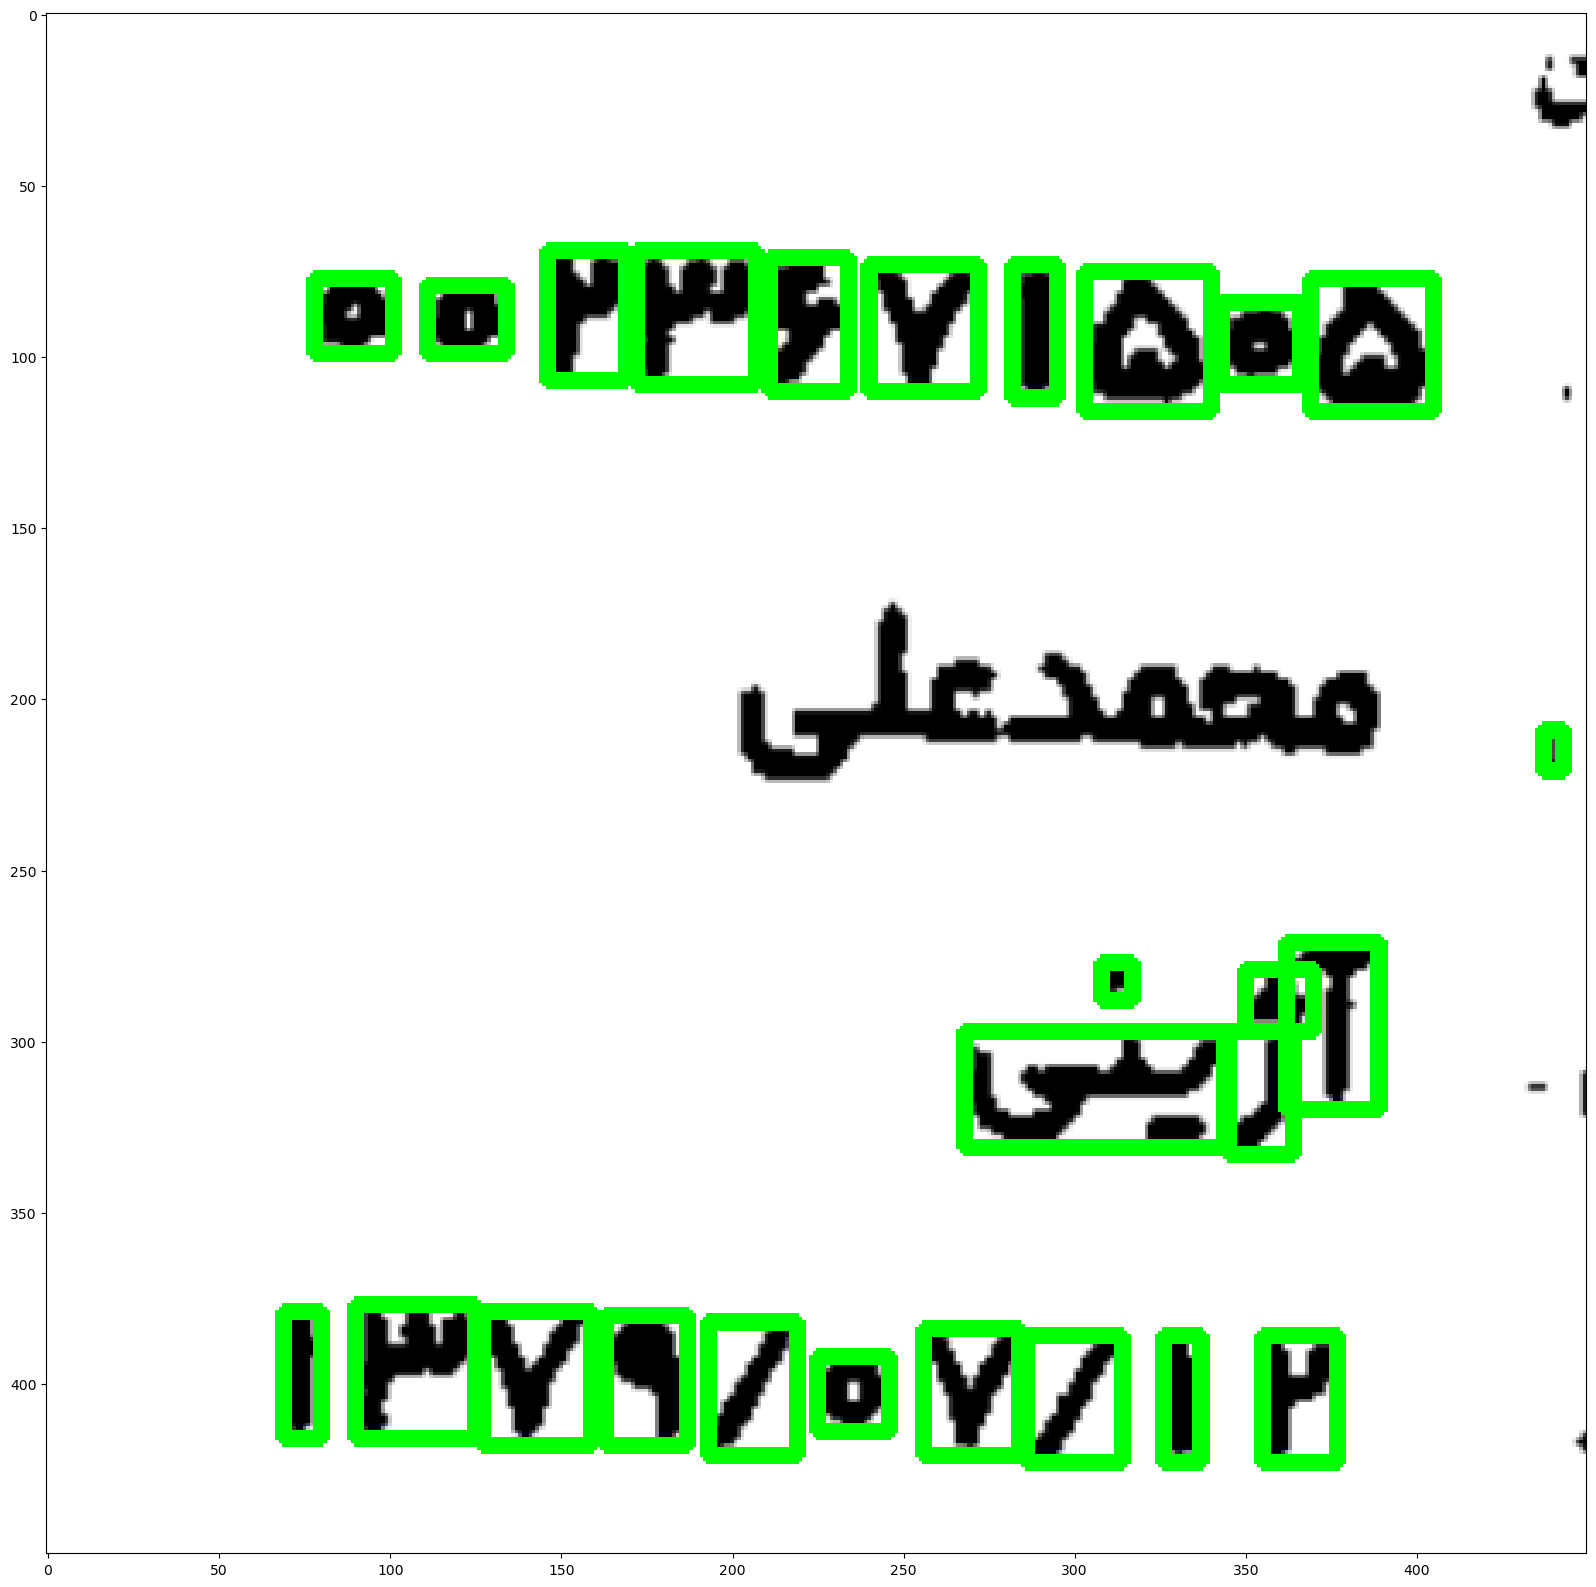

This is an ID Card
National ID: 0023671505
Expiration Date: 1379/07/12
Numbers are Persian


In [22]:

def template_matching(filtered_rectangles, templates):
    # crop rectangles and compare with candidates
    scores = {(x, y, w, h): {template: 0 for template in templates} for (x, y, w, h) in filtered_rectangles}
    for (x, y, w, h) in filtered_rectangles:
        crop_img = modified_image[y:y+h, x:x+w]
        for template in templates:
            max_score = 0
            for candid_template in templates[template]:
                # make size equal
                candid_template = cv2.resize(candid_template, (crop_img.shape[1], crop_img.shape[0]))
                # compare in CCOEFF_NORMED
                res = cv2.matchTemplate(crop_img, candid_template, cv2.TM_CCOEFF_NORMED)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
                if max_val > max_score:
                    max_score = max_val
            scores[(x, y, w, h)][template] = max_score

    # find max score
    max_scores = {}
    for (x, y, w, h) in filtered_rectangles:
        # set key of max_scores
        number = -1
        max_score = 0
        for template in templates:
            if scores[(x, y, w, h)][template] > max_score:
                max_score = scores[(x, y, w, h)][template]
                number = template
        max_scores[(x, y, w, h)] = number if max_score > 0.1 else None

    # sort by x
    filtered_rectangles = sorted(filtered_rectangles, key=lambda x: x[0])

    data = ""
    # draw number
    for (x, y, w, h) in filtered_rectangles:
        char = max_scores.get((x, y, w, h))
        if char is None:
            continue
        cv2.putText(matched_image, max_scores[(x, y, w, h)], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        if char == 'slash.png':
            char = '/.png'
        data += char.split('.')[0]


    # Display the image
    # plt.figure(figsize=(20, 20))
    # plt.imshow(matched_image)
    # plt.show()

    return data


def template_matching(filtered_rectangles, templates):
    # crop rectangles and compare with candidates
    scores = {(x, y, w, h): {template: 0 for template in templates} for (x, y, w, h) in filtered_rectangles}
    for (x, y, w, h) in filtered_rectangles:
        crop_img = image[y:y+h, x:x+w]
        for template in templates:
            max_score = 0
            for candid_template in templates[template]:
                # make size equal
                candid_template = cv2.resize(candid_template, (crop_img.shape[1], crop_img.shape[0]))
                # compare in CCOEFF_NORMED
                res = cv2.matchTemplate(crop_img, candid_template, cv2.TM_CCOEFF_NORMED)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
                if max_val > max_score:
                    max_score = max_val
            scores[(x, y, w, h)][template] = max_score

    # find max score
    max_scores = {}
    for (x, y, w, h) in filtered_rectangles:
        # set key of max_scores
        number = -1
        max_score = 0
        for template in templates:
            if scores[(x, y, w, h)][template] > max_score:
                max_score = scores[(x, y, w, h)][template]
                number = template
        max_scores[(x, y, w, h)] = number if max_score > 0.1 else None

    # sort by x
    filtered_rectangles = sorted(filtered_rectangles, key=lambda x: x[0])

    data = ""
    # draw number
    for (x, y, w, h) in filtered_rectangles:
        char = max_scores.get((x, y, w, h))
        if char is None:
            continue
        cv2.putText(matched_image, max_scores[(x, y, w, h)], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        if char == 'slash.png':
            char = '/.png'
        data += char.split('.')[0]


    # Display the image
    # plt.figure(figsize=(20, 20))
    # plt.imshow(matched_image)
    # plt.show()

    return data

def generate_templates(dataset_name):
    template_images = ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', 'slash.png']
    # Make candidates
    templates = {template: [] for template in template_images}
    for template in template_images:
        i = 1
        while True:
            try:
                imread_template = cv2.imread('./'+ dataset_name + '_' + str(i) + "/" + template, 0)
                templates[template] += make_templates(imread_template)
            except:
                break
            i += 1

    return templates


# Check if card is a bank card or national card
def is_national_card(image):
    # print("allah shape:", image.shape)
    allah = image[700:1000 , 0:300]
    allah_template = cv2.imread('sun.png', 0)
    # print("allah_template shape:", allah_template.shape)
    # Template matching
    # Resize allah_template to match the size of allah
    # allah_template = cv2.resize(allah_template, (allah.shape[1], allah.shape[0]))
    
    res = cv2.matchTemplate(allah, allah_template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.3
    # Show hit map
    loc = np.where(res >= threshold)
    # Print max score
    # print(np.max(res))
    if len(loc[0]) > 0:
        return True
    else:
        return False
        
        
image = modified_image
    
if is_national_card(modified_image):
    # Generate templates for national card
    templates = generate_templates('Fa_dataset')
    # Crop image to region of interest
    image = image[200:650, 800:1250]
    # Extract clustered rectangles from ROI
    clustered_rectangles, matched_image = fa_extract_segments(image)
    print("This is an ID Card")
    for cluster in clustered_rectangles:
        # Perform template matching on the cluster
        phrase = template_matching(cluster, templates)
        # print("temps :", phrase)
        if "/" in phrase:
            print("Expiration Date:", phrase)
            continue
            slash_index = phrase.index("/")
            expir_date = phrase[slash_index - 2: slash_index + 3]
            if len(phrase) >= 7 and slash_index >= 4:
                print("Expiration Date:", expir_date)
        elif len(phrase) == 10:
            national_id = phrase
            print("National ID:", national_id)
    print("Numbers are Persian")
else:
    # Generate templates for bank card
    templates = generate_templates('dataset')
    # Extract clustered rectangles from image
    clustered_rectangles, matched_image = extract_segments(image)
    print("This is a Bank Card")
    for cluster in clustered_rectangles:
        # Perform template matching on the cluster
        phrase = template_matching(cluster, templates)
        if "/" in phrase:
            slash_index = phrase.index("/")
            expir_date = phrase[slash_index - 2: slash_index + 3]
            if len(phrase) >= 7 and slash_index >= 4:
                print("Expiration Date:", expir_date)
        elif len(phrase) == 16:
            card_number = phrase
            print(f"Code Number : {card_number[0:4]} {card_number[4:8]} {card_number[8:12]} {card_number[12:16]}")
    print("Numbers are English")


In [ ]:
def predict(image):
         
image = modified_image
    
if is_national_card(modified_image):
    # Generate templates for national card
    templates = generate_templates('Fa_dataset')
    # Crop image to region of interest
    image = image[200:650, 800:1250]
    # Extract clustered rectangles from ROI
    clustered_rectangles, matched_image = fa_extract_segments(image)
    print("This is an ID Card")
    for cluster in clustered_rectangles:
        # Perform template matching on the cluster
        phrase = template_matching(cluster, templates)
        # print("temps :", phrase)
        if "/" in phrase:
            print("Expiration Date:", phrase)
            continue
            slash_index = phrase.index("/")
            expir_date = phrase[slash_index - 2: slash_index + 3]
            if len(phrase) >= 7 and slash_index >= 4:
                print("Expiration Date:", expir_date)
        elif len(phrase) == 10:
            national_id = phrase
            print("National ID:", national_id)
    print("Numbers are Persian")
    return "This is an ID Card" , national_id, expir_date , "Numbers are Persian"
else:
    # Generate templates for bank card
    templates = generate_templates('dataset')
    # Extract clustered rectangles from image
    clustered_rectangles, matched_image = extract_segments(image)
    print("This is a Bank Card")
    for cluster in clustered_rectangles:
        # Perform template matching on the cluster
        phrase = template_matching(cluster, templates)
        if "/" in phrase:
            slash_index = phrase.index("/")
            expir_date = phrase[slash_index - 2: slash_index + 3]
            if len(phrase) >= 7 and slash_index >= 4:
                print("Expiration Date:", expir_date)
        elif len(phrase) == 16:
            card_number = phrase
            print(f"Code Number : {card_number[0:4]} {card_number[4:8]} {card_number[8:12]} {card_number[12:16]}")
            x = {card_number[0:4]} {card_number[4:8]} {card_number[8:12]} {card_number[12:16]}
    print("Numbers are English")
    return "This is an Bank Card" , x, expir_date , "Numbers are English"       
